# Project: Wrangle and Analyze Data

## Data Gathering
In this section, we will gather all the three datasets for our analysis. The methods for the process are different.
#### 1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
# Importing all the libraries for our analysis
import pandas as pd
import numpy as np
import seaborn as sns
import requests 
import tweepy
import time

# This will be used to load the json data
import json
import os

# This will handle all regular expresiions issue
import re

from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

# Setting the style of the plots
sns.set(style='darkgrid', font_scale = 1.6)

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

#### 2. We will use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)

# Saving the image-prediction file
with open('image-predictions.tsv', 'wb') as file:
    file.write(response.content) 

In [4]:
# Loading the image-prediction file for our analysis
img_predictions = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
img_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [7]:
# Finding out more on my image prediction data
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### 3. Based on the information we have currently, we can't see the favorite counts (likes) and the retweet counts. As a result, We will use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [8]:
# #Setting up API credentials for the Tweepy API scraping process
consumer_key = '*******************************'
consumer_secret = '*******************************'
access_token = '**************************************************************'
access_secret = '*******************************'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), 
                  wait_on_rate_limit = True)
# , wait_on_rate_limit_notify =True

In [9]:
# Creating a list of tweet ids from the enhanced archive data.
tweet_id = twitter_archive.tweet_id
list(tweet_id)

#### 4. Getting the additional information (favorites and retweet_counts) using the tweepy API for the tweet ids listed in the previous cell.

> **Note**: There are chances that some tweet ids might not be found by the API and this could be because the tweet is deleted. To take of this possibility, we would be using the try and except function for the API get.
While the **try** function will get the favorites and retweet_counts of all available tweet ids, the except function will fetch a list of tweet ids that are not found.

In [10]:
# Getting additional data using the twitter API for the ids in the tweet_id variable.

# New list fot the twitter archive.
json_list = []

# We also need to create an error list for tweet ids that might not be found by the API which are on the tweet id list
error_list = []

# Creating a for loop to get the favorite and retweet counts of all the tweet ids in the tweet_id list.
for id in tweet_id:
    try:
        tweet_page = api.get_status(id, tweet_mode = 'extended')
        favorites = tweet_page['favorite_count']
        retweet_count = tweet_page['retweet_count']
        json_list.append({'tweet_id': int(id),
                         'favorites': int(favorites),
                         'retweet_count': int(retweet_count)
                        })
        print(id, favorite, retweet_count)
    except Exception as e:
        error_list.append(id)

In [11]:
# json_list

In [12]:
# error_list

<ul>In order to be sure that the exception list is actually unavailable, we will re-iterate the process, but this time, with the error list generated in the last iteration.</ul>

In [13]:
new_error_list = []

for error in error_list:
    try:
        data = api.get_status(error, tweet_mode = 'extended')
        favorites = data['favorite_count']
        retweet_count = data['retweet_count']
        new_list.append({'tweet_id': int(error),
                         'favorites': int(favorites),
                         'retweet_count': int(retweet_count)
                        })
        print(error, favorites, retweet_count)
    except Exception as e:
        new_error_list.append(error)
        

In [16]:
# Creating a pandas dataframe for our new list data
json_data = pd.DataFrame(json_list, columns = ['tweet_id', 'favorites', 'retweet_count'])

In [17]:
json_data.info()

In [18]:
duplicates = json_data[json_data.duplicated(keep='first')]
duplicates1 = json_data[json_data.duplicated(keep='last')]

In [19]:
duplicates.head(30)

In [20]:
duplicates1.head(30)

In [21]:
# exporting the data to tweet_json txt file 
json_data.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [22]:
# Reading the data for further analysis

json_df = pd.read_csv('tweet_json.txt')

In [23]:
json_df.head()

,tweet_id,favorites,retweet_count
0,892420643555336193,33812,7009
1,892177421306343426,29329,5302
2,891815181378084864,22055,3481
3,891689557279858688,36940,7226
4,891327558926688256,35311,7761


In [24]:
# More information about the json tweet data
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   tweet_id       2325 non-null   int64
 1   favorites      2325 non-null   int64
 2   retweet_count  2325 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


In [25]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [26]:
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
# Checking the last 20 rows of the twitter archive 
twitter_archive.tail(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2336,666273097616637952,NaN,NaN,2015-11-16 15:14:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Can take selfies 11/10 https://t.co/ws2AMaNwPW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666273097...,11,10,None,None,None,None,None
2337,666268910803644416,NaN,NaN,2015-11-16 14:57:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Very concerned about fellow dog trapped in com...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666268910...,10,10,None,None,None,None,None
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Not familiar with this breed. No tail (weird)....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,None,None,None
2339,666102155909144576,NaN,NaN,2015-11-16 03:55:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my. Here you are seeing an Adobe Setter giv...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666102155...,11,10,None,None,None,None,None
2340,666099513787052032,NaN,NaN,2015-11-16 03:44:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Can stand on stump for what seems like a while...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666099513...,8,10,None,None,None,None,None
2341,666094000022159362,NaN,NaN,2015-11-16 03:22:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This appears to be a Mongolian Presbyterian mi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666094000...,9,10,None,None,None,None,None
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100...,10,10,None,None,None,None,None
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193...,9,10,None,None,None,None,None
2345,666063827256086533,NaN,NaN,2015-11-16 01:22:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest dog you will ever see. Ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666063827...,10,10,the,None,None,None,None


In [28]:
# Checking the number of retweets in our twitter archive
retweets = twitter_archive.retweeted_status_id.value_counts().sum()
print('There are {} retweets'.format(retweets))

There are 181 retweets


In [29]:
# Checking the number of replies in the twitter archive
replies = twitter_archive.in_reply_to_status_id.value_counts().sum()
print('There are {} replies'.format(replies))

There are 78 replies


## Assessing Data
In this section, we will detect and document at least **eight (8) quality issues and two (2) tidiness issue** using **both** visual and programmatic assessements to assess the data.

* Also, we only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
.



### Quality issues
1. The Twitter Archive (twitter_archive) has 2356 entries while the image prediction (img_predictions) data has only 2075 entries. This could be as a result of retweet values and replies which the img_predictions do not have.

2. The rating_denominator in the twitter_archive is not consistent. We have a value as low as 6 and one as high as 170. Based on provided information, the rating denominator should be 10 for all entries.

3. The rating numerator contains outrageous values

4. timestamp and retweeted_status_timestamp should be datetime format instead of object.

5. timestamp column has +0000 which is not necessary

6. The datatypes are not consistent for some of the columns

7. Some dog names are not correct like a, an, the

8. Our dataset contains 181 retweets and 78 replies which are not needed for our analysis, since we are focusing on actual tweets.

### Tidiness issues
9. The three tables need to be merged into one dataframe the purpose of our analysis.

10. The variables, doggo, floofer, pupper, puppo need to be in a single column.

## Cleaning Data
In this section, we will clean **all** of the issues documented during the assessment. 

As always advised, we will make a copy of our original datasets before starting the cleaning process

In [30]:
# Creating a copy of the original datasets
cleaned_archive = twitter_archive.copy()
cleaned_json = json_df.copy()
cleaned_image = img_predictions.copy()

### Issue #9: The three tables need to be merged into one dataframe the purpose of our analysis.

### Define:

The three tables will be merged in order for us to carry out further analysis. This will make it possible for us to analyse the data once.

### Code

In [31]:
# Merging the archive and json datasets into one using the tweet_id as our primary key
merge_archive_json = pd.merge(cleaned_archive, cleaned_json, on=['tweet_id','tweet_id'],how='left') 

In [32]:
# Confirming if the merging worked fine
merge_archive_json.tail(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweet_count
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,112.0,39.0
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None,2293.0,423.0


In [33]:
# We will now merge the image prediction table with the merge_archive_json
new_merged_df = pd.merge(merge_archive_json, cleaned_image, on=['tweet_id', 'tweet_id'], how='left')

In [34]:
new_merged_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [35]:
# In order to view the entire column at once, we will need to set max column to the maximum number of columns our dataframe has
# We have about 30 columns in our dataset, so we will set max columns to 30
pd.set_option('display.max_columns', 30)

In [36]:
new_merged_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,33812.0,7009.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,29329.0,5302.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [37]:
# We will make a copy of the new merged dataframe before we begin our cleaning operations
merged_df = new_merged_df.copy()

### Issue #1: The Twitter Archive (twitter_archive) has 2356 entries while the image prediction (img_predictions) data has only 2075 entries. This could be as a result of retweet values and replies which the img_predictions do not have.

#### Define: 

 We will remove all rows that do not contain images. 

#### Code

In [38]:
merged_df.jpg_url.isnull().value_counts()

False    2075
True      281
Name: jpg_url, dtype: int64

In [39]:
merged_df= merged_df[merged_df.jpg_url.notnull()]

#### Test

In [40]:
merged_df.jpg_url.isnull().value_counts()

False    2075
Name: jpg_url, dtype: int64

In [41]:
merged_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,33812.0,7009.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,29329.0,5302.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


### Issue #2: The rating_denominator in the twitter_archive is not consistent. We have a value as low as 6 and one as high as 170. Based on provided information, the rating denominator should be 10 for all entries.

### Define

We will have to correct the rating values by looking at the content of the text column for more information

### Code

In [42]:
merged_df.rating_denominator.value_counts()

10     2057
50        3
11        2
80        2
70        1
7         1
150       1
170       1
20        1
90        1
40        1
130       1
110       1
120       1
2         1
Name: rating_denominator, dtype: int64

In [43]:
# Assessing the full text length to find out more about the ratings
pd.set_option('display.max_colwidth', 300)
pd.DataFrame(merged_df.text)

,text
0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f"
...,...
2351,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq
2352,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx
2353,Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR
2354,This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI


> We will focus on the tweets and their rating denominators. Also, considering tha the texts contain the actual ratings, we will be using it to confirm the ratings of the inconsistent rating denominators

In [44]:
tweet_rating = merged_df[['tweet_id', 'text', 'rating_numerator','rating_denominator']]

In [45]:
# Fetching rating denon
tweet_rating.query('rating_denominator !=10')

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


<h4> We will correct the values that are closer to the actual expected rating. For the outragious values, they appear to be a cumulative rating from different users</h4>

In [46]:
# Since we don't have a single value for the numerator, we will manually fit the correct values.
merged_df.loc[merged_df.tweet_id == 740373189193256964, 'rating_numerator'] = 14
merged_df.loc[merged_df.tweet_id == 722974582966214656, 'rating_numerator'] = 13
merged_df.loc[merged_df.tweet_id == 716439118184652801, 'rating_numerator'] = 11
merged_df.loc[merged_df.tweet_id == 682962037429899265, 'rating_numerator'] = 10
merged_df.loc[merged_df.tweet_id == 666287406224695296, 'rating_numerator'] = 9

In [47]:
# We will use a for loop to iterate through the tweet_ids with actual rating_denominator of 10.
den = [740373189193256964, 722974582966214656, 716439118184652801, 682962037429899265, 666287406224695296]

for i in den:
    merged_df.loc[merged_df.tweet_id==i, 'rating_denominator'] = 10

<h4>By viewing the rating denominator, we can confirm that the value count for the rating denominator of 10 has increased.</h4>

### Test

In [48]:
merged_df.rating_denominator.value_counts()

10     2062
80        2
50        2
70        1
7         1
150       1
170       1
90        1
40        1
130       1
110       1
120       1
Name: rating_denominator, dtype: int64

### Issue #3: The rating numerator contains outrageous values 

### Define

According to this, <a href="https://www.matthewunrue.com/Projects/Udacity/WeRateDogs/Project.html">site</a>, average value of the numerator should be between 12 and 13. So, we are going to set all values of the numerator above 14 to 13.

### Code

In [49]:
merged_df.rating_numerator.value_counts()

12      474
10      430
11      414
13      285
9       151
8        95
7        51
14       41
5        34
6        32
3        19
4        15
2         9
1         4
0         2
27        1
60        1
88        1
144       1
26        1
121       1
143       1
44        1
45        1
75        1
80        1
99        1
204       1
1776      1
165       1
15        1
84        1
24        1
420       1
Name: rating_numerator, dtype: int64

In [50]:
merged_df.loc[merged_df['rating_numerator']>14, 'rating_numerator'] = 13

#### Test

In [51]:
merged_df.rating_numerator.value_counts()

12    474
10    430
11    414
13    304
9     151
8      95
7      51
14     41
5      34
6      32
3      19
4      15
2       9
1       4
0       2
Name: rating_numerator, dtype: int64

In [52]:
merged_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,33812.0,7009.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,29329.0,5302.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,22055.0,3481.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,36940.0,7226.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,35311.0,7761.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### Issues #4 and #5: timestamp column has +0000 which is not necessary, and timestamp should be datetime format instead of object.  

### Define
We will remove the unncessary +0000 values attached to the timestamp
The datatype of the timestamp will be changed to datetime.

### Code

In [53]:
# Removing the +0000 value from the timestamp
merged_df.timestamp = merged_df.timestamp.str.strip('+0000')

In [54]:
# Converting the timestamp column to datetime
merged_df.timestamp = pd.to_datetime(merged_df.timestamp)

### Test

In [55]:
merged_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorites,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,33812.0,7009.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


In [56]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2075 non-null   int64         
 1   in_reply_to_status_id       23 non-null     float64       
 2   in_reply_to_user_id         23 non-null     float64       
 3   timestamp                   2075 non-null   datetime64[ns]
 4   source                      2075 non-null   object        
 5   text                        2075 non-null   object        
 6   retweeted_status_id         81 non-null     float64       
 7   retweeted_status_user_id    81 non-null     float64       
 8   retweeted_status_timestamp  81 non-null     object        
 9   expanded_urls               2075 non-null   object        
 10  rating_numerator            2075 non-null   int64         
 11  rating_denominator          2075 non-null   int64       

### Issue #6: The datatypes are not consistent for some of the columns

### Define
We will convert each column to their appropriate datatype

### Code

In [57]:
# Creating a list of the category for the iteration
category = ['name', 'doggo', 'floofer', 'pupper', 'puppo', 'source']



for c in category:
    merged_df[c] = merged_df[c].astype('category')

    
merged_df['tweet_id'] = merged_df['tweet_id'].astype(object)


### Test

In [58]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2075 non-null   object        
 1   in_reply_to_status_id       23 non-null     float64       
 2   in_reply_to_user_id         23 non-null     float64       
 3   timestamp                   2075 non-null   datetime64[ns]
 4   source                      2075 non-null   category      
 5   text                        2075 non-null   object        
 6   retweeted_status_id         81 non-null     float64       
 7   retweeted_status_user_id    81 non-null     float64       
 8   retweeted_status_timestamp  81 non-null     object        
 9   expanded_urls               2075 non-null   object        
 10  rating_numerator            2075 non-null   int64         
 11  rating_denominator          2075 non-null   int64       

### Issue #7: Some dog names are not correct like a, an, the.

### Define

We will change the names that are not consistent to None

### Code

- The inconsistent names are the ones starting with lower case, so we will use that to filter

In [59]:
# We see all incorrect names have their first letter has lowercase. We will use this to change them into 'None'. 
dog_names=[]

# The function iterates through name column checking if the first letter is lowercase.
def wrong_dog_name(name_row):
    if name_row['name'][0].islower() == True:
        dog_names.append('None')
    else:
        dog_names.append(name_row['name'])
        
# call function using pandas apply by columns
merged_df.apply(wrong_dog_name, axis=1)


#add names list to master dataframe and check dataframe
merged_df['names'] = dog_names

### Test

In [60]:
merged_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,puppo,favorites,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,names
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,...,None,33812.0,7009.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,Phineas
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,...,None,29329.0,5302.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Tilly
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,...,None,22055.0,3481.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Archie
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,...,None,36940.0,7226.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,Darla
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,...,None,35311.0,7761.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,Franklin


### Issue #8: Our dataset contains 181 retweets and 78 replies which are not needed for our analysis, since we are focusing on actual tweets.

### Define

We will drop the retweets and replies

### Code

In [61]:
# Dropping the irrelevant colummns
merged_df = merged_df[merged_df.retweeted_status_id.isnull()]


In [62]:
merged_df = merged_df.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

### Test

In [63]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1994 non-null   object        
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              1994 non-null   datetime64[ns]
 4   source                 1994 non-null   category      
 5   text                   1994 non-null   object        
 6   expanded_urls          1994 non-null   object        
 7   rating_numerator       1994 non-null   int64         
 8   rating_denominator     1994 non-null   int64         
 9   name                   1994 non-null   category      
 10  doggo                  1994 non-null   category      
 11  floofer                1994 non-null   category      
 12  pupper                 1994 non-null   category      
 13  pup

In [64]:
# Exteacting the tweet source using the regular expression library 're'
merged_df['source'] = merged_df['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

In [65]:
merged_df.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

### Issue #10: The variables, doggo, floofer, pupper, puppo need to be in a single column

In [66]:
merged_df[['doggo', 'floofer', 'pupper', 'puppo']].value_counts().to_list()

[1688, 203, 63, 22, 9, 7, 1, 1]

In [67]:
# Checking the count of each dog breed
dog_breeds = ['doggo', 'floofer', 'pupper', 'puppo']
for i in dog_breeds:
    x = pd.DataFrame(merged_df[i].value_counts())
    print(x)

       doggo
None    1920
doggo     74
         floofer
None        1986
floofer        8
        pupper
None      1782
pupper     212
       puppo
None    1971
puppo     23


In [68]:
# Collapsing the dog_breeds into one column for proper analysis.
merged_df = pd.melt(merged_df, 
        id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'favorites', 'retweet_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'], 
        value_vars = ['doggo', 'floofer', 'pupper', 'puppo'], 
        var_name = 'types', value_name = 'dog_type')

<h4>After the melting process, we have many duplicated tweet_ids. So we will need to drop those duplicated ids for our analysis to be accurate </h3>

In [69]:
# Dropping the duplicated tweets by their ids
merged_df = merged_df.sort_values('dog_type').drop_duplicates('tweet_id', keep = 'last')

In [70]:
merged_df.tail(30)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,types,dog_type
5200,690015576308211712,2016-01-21 03:38:27,Twitter for iPhone,This pupper can only sleep on shoes. It's a crippling disease. Tearing his family apart. 12/10 I'd totally pet tho https://t.co/03XlvS8izg,"https://twitter.com/dog_rates/status/690015576308211712/photo/1,https://twitter.com/dog_rates/status/690015576308211712/photo/1",12,10,None,2311.0,664.0,https://pbs.twimg.com/media/CZNtgWhWkAAbq3W.jpg,2.0,malamute,0.949609,True,Siberian_husky,0.033084,True,Eskimo_dog,0.016663,True,pupper,pupper
5513,675113801096802304,2015-12-11 00:44:07,Twitter for iPhone,Meet Zuzu. He just graduated college. Astute pupper. Needs 2 leashes to contain him. Wasn't ready for the pic. 10/10 https://t.co/2H5SKmk0k7,https://twitter.com/dog_rates/status/675113801096802304/photo/1,10,10,Zuzu,1740.0,690.0,https://pbs.twimg.com/media/CV58a4nXAAApywo.jpg,1.0,bow,0.168020,False,quill,0.108807,False,joystick,0.043312,False,pupper,pupper
5204,689905486972461056,2016-01-20 20:21:00,Twitter for iPhone,"Say hello to Gizmo. He's quite the pupper. Confused by bed, but agile af. Can barely catch on camera. 11/10 so quick https://t.co/IE4ZblyZRY","https://twitter.com/dog_rates/status/689905486972461056/photo/1,https://twitter.com/dog_rates/status/689905486972461056/photo/1,https://twitter.com/dog_rates/status/689905486972461056/photo/1,https://twitter.com/dog_rates/status/689905486972461056/photo/1",11,10,Gizmo,2263.0,624.0,https://pbs.twimg.com/media/CZMJYCRVAAE35Wk.jpg,4.0,Pomeranian,0.943331,True,Shetland_sheepdog,0.023675,True,chow,0.007165,True,pupper,pupper
4064,874296783580663808,2017-06-12 16:06:11,Twitter for iPhone,This is Jed. He may be the fanciest pupper in the game right now. Knows it too. 13/10 would sign modeling contract https://t.co/0YplNnSMEm,https://twitter.com/dog_rates/status/874296783580663808/photo/1,13,10,Jed,22969.0,3483.0,https://pbs.twimg.com/media/DCIgSR0XgAANEOY.jpg,1.0,cocker_spaniel,0.437216,True,miniature_poodle,0.277191,True,toy_poodle,0.157402,True,pupper,pupper
5543,674447403907457024,2015-12-09 04:36:06,Twitter for iPhone,This pupper just wants a belly rub. This pupper has nothing to do w the tree being sideways now. 10/10 good pupper https://t.co/AyJ7Ohk71f,https://twitter.com/dog_rates/status/674447403907457024/photo/1,10,10,None,957.0,315.0,https://pbs.twimg.com/media/CVweVUfW4AACPwI.jpg,1.0,Brabancon_griffon,0.409909,True,malinois,0.244649,True,bull_mastiff,0.074819,True,pupper,pupper
5057,702598099714314240,2016-02-24 20:56:55,Twitter for iPhone,"This is Sansa. She's gotten too big for her chair. Not so smol anymore. 11/10 once a pupper, always a pupper https://t.co/IpAoztle2s",https://twitter.com/dog_rates/status/702598099714314240/photo/1,11,10,Sansa,11354.0,3145.0,https://pbs.twimg.com/media/CcAhPevW8AAoknv.jpg,1.0,kelpie,0.219179,True,badger,0.133584,False,Siamese_cat,0.074440,False,pupper,pupper
5209,689623661272240129,2016-01-20 01:41:08,Twitter for iPhone,This is Lucy. She's terrified of the stuffed billed dog. 10/10 stay strong pupper https://t.co/QnvSjjyh7n,"https://twitter.com/dog_rates/status/689623661272240129/photo/1,https://twitter.com/dog_rates/status/689623661272240129/photo/1",10,10,Lucy,2046.0,581.0,https://pbs.twimg.com/media/CZIJD2SWIAMJgNI.jpg,1.0,toy_poodle,0.279604,True,mashed_potato,0.208564,False,Labrador_retriever,0.077481,True,pupper,pupper
6281,825026590719483904,2017-01-27 17:04:02,Twitter for iPhone,Say hello to Pablo. He's one gorgeous puppo. A true 12/10. Click the link to see why Pablo requests your assistance\n\nhttps://t.co/koHvVQp9bL https://t.co/IhW0JKf7kc,"https://www.gofundme.com/my-puppys-double-cataract-surgery,https://twitter.com/dog_rates/status/825026590719483904/photo/1,https://twitter.com/dog_rates/status/825026590719483904/photo/1",12,10,Pablo,5910.0,1168.0,https://pbs.twimg.com/media

In [71]:
# Dropping the 'types' column
merged_df.drop('types', axis=1, inplace=True)

In [72]:
# we need to also merge the dog breed and their confidence level.

dog_breed = []
confidence_level = []
def breed_conf(col):
    if col['p1_dog'] == True:
        dog_breed.append(col['p1'])
        confidence_level.append(col['p1_conf'])
    elif col['p2_dog'] == True:
        dog_breed.append(col['p2'])
        confidence_level.append(col['p2_conf'])
    elif col['p3_dog'] == True:
        dog_breed.append(col['p3'])
        confidence_level.append(col['p3_conf'])
    else:
        dog_breed.append('unknown_breed')
        confidence_level.append(0)
# We will use the apply function apply the properties of the breed_conf function to our dataframe
merged_df.apply(breed_conf, axis = 1)

#We will now effect the changes to our DataFrame, df_merged by adding the two lists created
merged_df['dog_breed'] = dog_breed
merged_df['confidence'] = confidence_level

In [73]:
merged_df.tail(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type,dog_breed,confidence
6044,878776093423087618,2017-06-25 00:45:22,Twitter for iPhone,This is Snoopy. He's a proud #PrideMonthPuppo. Impeccable handwriting for not having thumbs. 13/10 would love back #PrideMonth https://t.co/lNZwgNO4gS,"https://twitter.com/dog_rates/status/878776093423087618/photo/1,https://twitter.com/dog_rates/status/878776093423087618/photo/1",13,10,Snoopy,17139.0,3433.0,https://pbs.twimg.com/media/DDIKMXzW0AEibje.jpg,2.0,Italian_greyhound,0.734684,True,whippet,0.150487,True,Ibizan_hound,0.039725,True,puppo,Italian_greyhound,0.734684
6279,825535076884762624,2017-01-29 02:44:34,Twitter for iPhone,Here's a very loving and accepting puppo. Appears to have read her Constitution well. 14/10 would pat head approvingly https://t.co/6ao80wIpV1,https://twitter.com/dog_rates/status/825535076884762624/photo/1,14,10,None,53994.0,16363.0,https://pbs.twimg.com/media/C3TjvitXAAAI-QH.jpg,1.0,Rottweiler,0.681495,True,Tibetan_mastiff,0.147940,True,black-and-tan_coonhound,0.024525,True,puppo,Rottweiler,0.681495
6764,743253157753532416,2016-06-16 01:25:36,Twitter for iPhone,"This is Kilo. He cannot reach the snackum. Nifty tongue, but not nifty enough. 10/10 maybe one day puppo https://t.co/gSmp31Zrsx",https://twitter.com/dog_rates/status/743253157753532416/photo/1,10,10,Kilo,3935.0,1124.0,https://pbs.twimg.com/media/ClCQzFUUYAA5vAu.jpg,1.0,malamute,0.442612,True,Siberian_husky,0.368137,True,Eskimo_dog,0.177822,True,puppo,malamute,0.442612


In [74]:
# We will now drop those columns.
cols_drop = ['p1','p1_conf','p1_dog','p2','p2_conf', 'p2_dog','p3', 'p3_conf', 'p3_dog']

merged_df.drop(cols_drop, axis=1, inplace = True)

In [75]:
merged_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,jpg_url,img_num,dog_type,dog_breed,confidence
1918,667405339315146752,2015-11-19 18:13:27,Twitter for iPhone,This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,411.0,197.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,1.0,None,Saint_Bernard,0.381377
1917,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,266.0,76.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1.0,None,Rottweiler,0.999091
1916,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,396.0,198.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1.0,None,unknown_breed,0.000000
1915,667443425659232256,2015-11-19 20:44:47,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6,10,None,682.0,490.0,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,1.0,None,unknown_breed,0.000000
1914,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,Cupcake,279.0,74.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1.0,None,Labrador_retriever,0.825670


## Storing Data
We will now save the gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [76]:
merged_df.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, we will analyze and visualize the wrangled data. We will be producing up to **four (4) insights and accompanying visualizations**

In [77]:
# Loading the wrangled dataset into a new dataframe called, df_clean
df_clean = pd.read_csv('twitter_archive_master.csv')

In [78]:
df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,jpg_url,img_num,dog_type,dog_breed,confidence
0,667405339315146752,2015-11-19 18:13:27,Twitter for iPhone,This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,411.0,197.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,1.0,None,Saint_Bernard,0.381377
1,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,266.0,76.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1.0,None,Rottweiler,0.999091
2,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,396.0,198.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,1.0,None,unknown_breed,0.000000
3,667443425659232256,2015-11-19 20:44:47,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6,10,None,682.0,490.0,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,1.0,None,unknown_breed,0.000000
4,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,Cupcake,279.0,74.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1.0,None,Labrador_retriever,0.825670


In [79]:
df_clean.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

In [80]:
df_clean.describe()

,tweet_id,rating_numerator,rating_denominator,favorites,retweet_count,img_num,confidence
count,1.994000e+03,1994.000000,1994.000000,1984.000000,1984.000000,1994.000000,1994.000000
mean,7.358508e+17,10.573220,10.510030,7710.504032,2244.851815,1.203109,0.464991
std,6.747816e+16,2.187385,7.261522,11379.443289,4021.490596,0.560777,0.339470
min,6.660209e+17,0.000000,7.000000,66.000000,11.000000,1.000000,0.000000
25%,6.758475e+17,10.000000,10.000000,1644.250000,495.750000,1.000000,0.140466
50%,7.084748e+17,11.000000,10.000000,3464.500000,1080.000000,1.000000,0.459130
75%,7.877873e+17,12.000000,10.000000,9556.250000,2553.750000,1.000000,0.776386
max,8.924206e+17,14.000000,170.000000,144901.000000,70750.000000,4.000000,0.999956


In [81]:
# Sorting the number of dog_breeds in descending order
df_clean.dog_breed.value_counts().nlargest(15)

unknown_breed               308
golden_retriever            158
Labrador_retriever          108
Pembroke                     95
Chihuahua                    91
pug                          62
toy_poodle                   51
chow                         48
Pomeranian                   42
Samoyed                      42
malamute                     33
French_bulldog               31
Chesapeake_Bay_retriever     31
cocker_spaniel               30
miniature_pinscher           25
Name: dog_breed, dtype: int64

### Insights:
1. Which dog breed has the highest ratings?

2. Among the dog_breeds, which top 10 were tweeted most?

3. Which dog breed recorded the highest retweet count?

5. Which dog breed has the highest number of likes on average?

### Visualization

In [82]:
# We have dog_breed named "Unknown breed". These are breeeds that we are not able to identify.
# We need to remove them because they are not relevant to our analysis.
df_clean = df_clean[df_clean.dog_breed !='unknown_breed']

In [83]:
# Checking again
df_clean.dog_breed.value_counts().nlargest(15)

golden_retriever            158
Labrador_retriever          108
Pembroke                     95
Chihuahua                    91
pug                          62
toy_poodle                   51
chow                         48
Pomeranian                   42
Samoyed                      42
malamute                     33
Chesapeake_Bay_retriever     31
French_bulldog               31
cocker_spaniel               30
miniature_pinscher           25
Eskimo_dog                   22
Name: dog_breed, dtype: int64

In [84]:
# We will analyze the summary statistics of each dog breed based on their tweet rating, 
# and this is sorted in descending order of maximum tweet rating for the first 20 dog_breeds
df_clean.groupby('dog_breed')['rating_numerator'].describe().nlargest(20, 'mean')

,count,mean,std,min,25%,50%,75%,max
dog_breed,,,,,,,,
Bouvier_des_Flandres,1.0,13.000000,NaN,13.0,13.00,13.0,13.00,13.0
clumber,1.0,13.000000,NaN,13.0,13.00,13.0,13.00,13.0
Saluki,4.0,12.500000,1.000000,11.0,12.50,13.0,13.00,13.0
briard,3.0,12.333333,0.577350,12.0,12.00,12.0,12.50,13.0
Tibetan_mastiff,4.0,12.250000,0.500000,12.0,12.00,12.0,12.25,13.0
Border_terrier,7.0,12.142857,0.690066,11.0,12.00,12.0,12.50,13.0
silky_terrier,1.0,12.000000,NaN,12.0,12.00,12.0,12.00,12.0
standard_schnauzer,1.0,12.000000,NaN,12.0,12.00,12.0,12.00,12.0
Gordon_setter,4.0,11.750000,2.217356,9.0,10.50,12.0,13.25,14.0


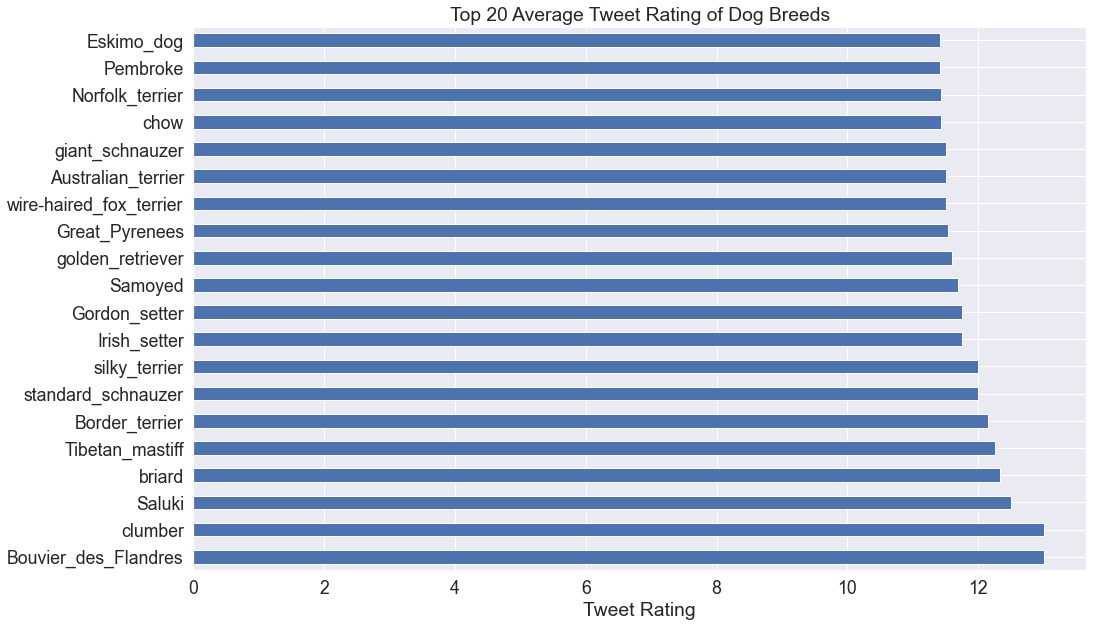

In [85]:
# We can analyze the average tweet rating of the top 20 dog breeds
plt.figure(figsize=(16,10))
df_clean.groupby('dog_breed')['rating_numerator'].mean().sort_values(ascending=False).nlargest(20).plot(kind='barh')
plt.title('Top 20 Average Tweet Rating of Dog Breeds')
plt.ylabel(None)
plt.xlabel('Tweet Rating');

- **Bourvier Des Flandres and Clumber recorded the highest average tweet rating with an average tweet rating of 13, followed by Saluki with average tweet rating of 12.5**

In [86]:
df_clean['dog_breed'].value_counts().nlargest(10).sort_values(ascending=False)

golden_retriever      158
Labrador_retriever    108
Pembroke               95
Chihuahua              91
pug                    62
toy_poodle             51
chow                   48
Pomeranian             42
Samoyed                42
malamute               33
Name: dog_breed, dtype: int64

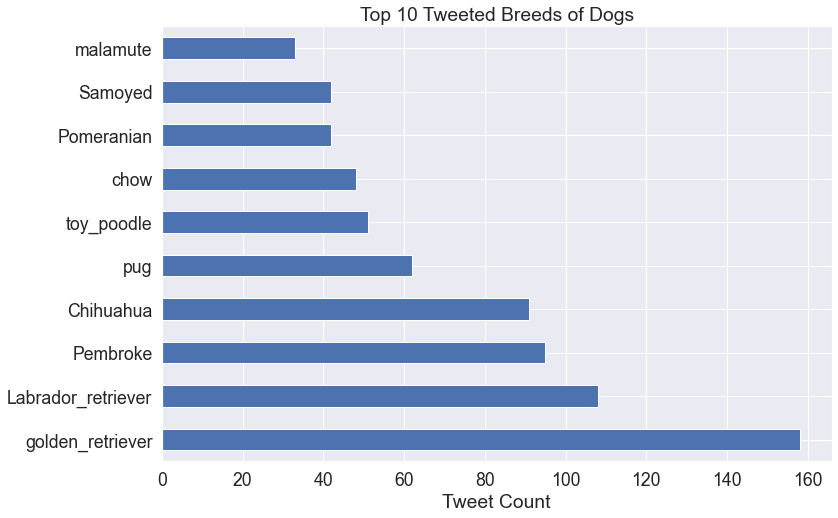

In [87]:
# We will now plot the top 10 dog breeds tweeted on the weratedog handle
plt.figure(figsize=(12,8))
df_clean['dog_breed'].value_counts().nlargest(10).sort_values(ascending=False).plot(kind='barh')
plt.xlabel('Tweet Count')
plt.title('Top 10 Tweeted Breeds of Dogs');

- **Golden Retriever recorded the highest tweet count of 158, followed by Labrador Retriever with tweet count of 108**

In [88]:
pd.DataFrame(df_clean.groupby('dog_breed')['retweet_count'].sum().nlargest(10))

,retweet_count
dog_breed,
golden_retriever,477396.0
Labrador_retriever,313615.0
Pembroke,236940.0
Chihuahua,210907.0
Samoyed,156134.0
French_bulldog,132219.0
cocker_spaniel,118787.0
chow,107263.0
pug,94427.0


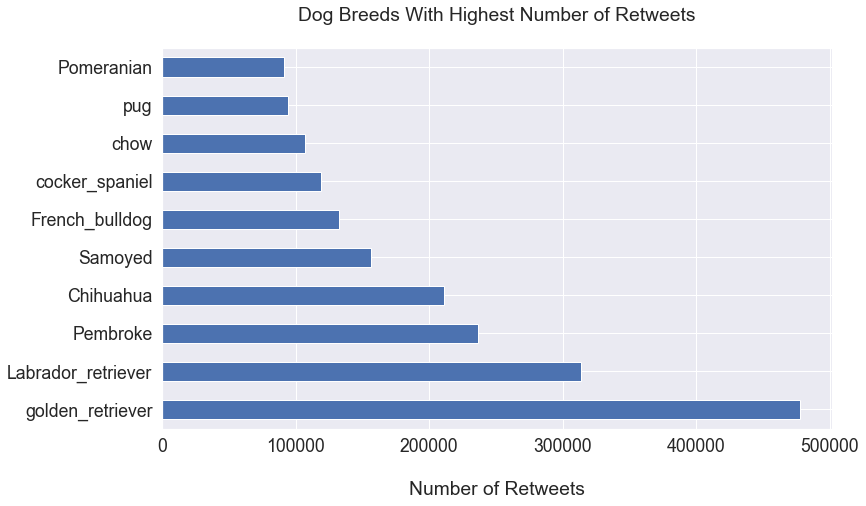

In [89]:
# Dog breeds with highest retweet count.
plt.figure(figsize = (12,7))
df_clean.groupby('dog_breed')['retweet_count'].sum().nlargest(10).plot(kind='barh', label=None)
plt.title('Dog Breeds With Highest Number of Retweets\n')
plt.ylabel(None)
plt.xlabel('\nNumber of Retweets');

- **Golden Retrieve has the highest number of retweets with over 470,000 retweets, and it is followed by Labrador Retriever with over 31,000 retweets**

**In order to find the average number of likes (favorites) per tweet per dog breed, we need to first find the total count of tweets and the total number of likes.**

In [90]:
# Number of retweet count for each dog
count_likes = df_clean.groupby('dog_breed')['favorites'].count()

In [91]:
sum_likes = df_clean.groupby('dog_breed')['favorites'].sum()

In [92]:
# Average number of likes per tweet per dog
avg_like = sum_likes/count_likes

In [93]:
avg_like.nlargest(10).nlargest(10)

dog_breed
Bedlington_terrier         22850.800000
Saluki                     20808.750000
French_bulldog             17540.666667
Bouvier_des_Flandres       15357.000000
Afghan_hound               14708.666667
black-and-tan_coonhound    14673.000000
flat-coated_retriever      14523.500000
Irish_water_spaniel        13981.666667
whippet                    12709.545455
Leonberg                   12659.000000
Name: favorites, dtype: float64

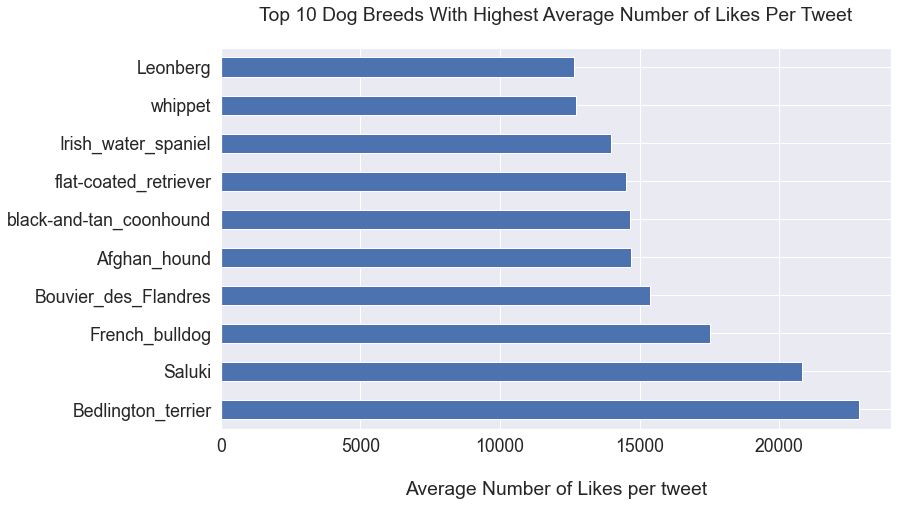

In [94]:
plt.figure(figsize = (12,7))
avg_like.nlargest(10).plot(kind='barh')
plt.title('Top 10 Dog Breeds With Highest Average Number of Likes Per Tweet\n')
plt.ylabel(None)
plt.xlabel('\nAverage Number of Likes per tweet');

- **Bedlington Terrier has the highest likes on average to the tune of 22,851 approximately, and it is followed by Saluki with approximately 20,809 likes on average**

# Conclusion

1. Bourvier Des Flandres and Clumber recorded the highest average tweet rating with an average tweet rating of 13, followed by Saluki with average tweet rating of 12.5.

2. Golden Retriever recorded the highest tweet count of 158, followed by Labrador Retriever with tweet count of 108.

3. Golden Retrieve has the highest number of retweets with over 470,000 retweets, and it is followed by Labrador Retriever with over 31,000 retweets.

4. Bedlington Terrier has the highest likes on average to the tune of 22,851 approximately, and it is followed by Saluki with approximately 20,809 likes on average

We can conclude that based on number, Golden Retriever is most popular dog breed in homes, while Berlington Terrier has the highest audience vote.

# References
https://en.wikipedia.org/wiki/WeRateDogs

https://www.dailydot.com/debug/twitter-dog-rates-dmca-takedown/

https://www.vice.com/en/article/aekvg8/twitter-rate-dogs-account-suspended

https://help.twitter.com/en/managing-your-account/how-to-download-your-twitter-archive
